## Quick notebook to calculate murphy skill score

Code from

https://github.com/PeterRochford/SkillMetrics/blob/master/skill_metrics/skill_score_murphy.py

Reference:
https://journals.ametsoc.org/view/journals/mwre/116/12/1520-0493_1988_116_2417_ssbotm_2_0_co_2.xml
Skill Scores Based on the Mean Square Error and Their Relationships to the Correlation Coefficient
Allan H. Murphy 
Print Publication: 01 Dec 1988

In [42]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [43]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seawater
import netCDF4 as nc
import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy
import gsw
import warnings

import numpy as np
from skill_metrics import rmsd

In [44]:
help(rmsd)

Help on function rmsd in module skill_metrics.rmsd:

rmsd(predicted, reference)
    Calculate root-mean-square deviation (RMSD) between two variables
    
    Calculates the root-mean-square deviation between two variables 
    PREDICTED and REFERENCE. The RMSD is calculated using the 
    formula:
    
    RMSD^2 = sum_(n=1)^N [(p_n - r_n)^2]/N
    
    where p is the predicted values, r is the reference values, and
    N is the total number of values in p & r. Note that p & r must
    have the same number of values.
    
    Input:
    PREDICTED : predicted values
    REFERENCE : reference values
    
    Output:
    R : root-mean-square deviation (RMSD)
    
    Author: Peter A. Rochford
        Symplectic, LLC
        www.thesymplectic.com
        prochford@thesymplectic.com
    
    Created on Dec 9, 2016



In [78]:


def skill_score_murphy(predicted,reference):
    '''
    Calculate non-dimensional skill score (SS) between two variables using
    definition of Murphy (1988)
    Calculates the non-dimensional skill score (SS) difference between two 
    variables PREDICTED and REFERENCE. The skill score is calculated using 
    the formula:
 
    SS = 1 - RMSE^2/SDEV^2
 
    where RMSE is the root-mean-squre error between the predicted and
    reference values
 
    (RMSE)^2 = sum_(n=1)^N (p_n - r_n)^2/N
 
    and SDEV is the standard deviation of the reference values
 
    SDEV^2 = sum_(n=1)^N [r_n - mean(r)]^2/(N-1)
 
    where p is the predicted values, r is the reference values, and
    N is the total number of values in p & r. Note that p & r must
    have the same number of values.
 
    Input:
    PREDICTED : predicted field
    REFERENCE : reference field
 
    Output:
    SS : skill score
    Reference:
    Allan H. Murphy, 1988: Skill Scores Based on the Mean Square Error 
    and Their Relationships to the Correlation Coefficient. Mon. Wea. 
    Rev., 116, 2417-2424.
    doi: http//dx.doi.org/10.1175/1520-0493(1988)<2417:SSBOTM>2.0.CO;2
    
    Author: Peter A. Rochford
        Symplectic, LLC
        www.thesymplectic.com
        prochford@thesymplectic.com
    Created on Dec 7, 2016
    '''

    # Check that dimensions of predicted and reference fields match
    pdims= predicted.shape
    rdims= reference.shape
    if not np.array_equal(pdims,rdims):
        message = 'predicted and reference field dimensions do not' + \
            ' match.\n' + \
            'shape(predicted)= ' + str(pdims) + ', ' + \
            'shape(reference)= ' + str(rdims) + \
            '\npredicted type: ' + str(type(predicted))
        raise ValueError(message)
    
    # Calculate RMSE
    rmse2 = rmsd(predicted,reference)**2
    
    # Calculate standard deviation
    sdev2 = np.std(reference,ddof=1)**2

    #% Calculate skill score
    ss = 1 - rmse2/sdev2

    return ss

In [79]:
help(skill_score_murphy)

Help on function skill_score_murphy in module __main__:

skill_score_murphy(predicted, reference)
    Calculate non-dimensional skill score (SS) between two variables using
    definition of Murphy (1988)
    Calculates the non-dimensional skill score (SS) difference between two 
    variables PREDICTED and REFERENCE. The skill score is calculated using 
    the formula:
    
    SS = 1 - RMSE^2/SDEV^2
    
    where RMSE is the root-mean-squre error between the predicted and
    reference values
    
    (RMSE)^2 = sum_(n=1)^N (p_n - r_n)^2/N
    
    and SDEV is the standard deviation of the reference values
    
    SDEV^2 = sum_(n=1)^N [r_n - mean(r)]^2/(N-1)
    
    where p is the predicted values, r is the reference values, and
    N is the total number of values in p & r. Note that p & r must
    have the same number of values.
    
    Input:
    PREDICTED : predicted field
    REFERENCE : reference field
    
    Output:
    SS : skill score
    Reference:
    Allan H. Murphy

In [80]:
ss_dic = np.zeros([5]); ss_alk = np.zeros([5]); ss_OmegaA = np.zeros([5])

for i in range(0,5):

    yr = 2013+i
    dset = 'COMB'
    fname_obs = f'./extracted_calculated/OBS_{dset}_MASKED_umolL.csv'
    fname_mod = f'./extracted_calculated/YR{yr}_{dset}_salspace_modeloutput_with_Omega.csv'

    df_obs = pd.read_csv(fname_obs)
    dic_obs = df_obs['dic'].to_numpy()
    alk_obs = df_obs['alk'].to_numpy()
    OmegaA_obs = df_obs['OmegaA'].to_numpy()

    df_mod = pd.read_csv(fname_mod)
    dic_mod = df_mod['dic'].to_numpy()
    alk_mod = df_mod['alk'].to_numpy()
    OmegaA_mod = df_mod['OmegaA'].to_numpy()

    dic_mod_m = dic_mod[~np.isnan(dic_mod)]
    dic_obs_m = dic_obs[~np.isnan(dic_mod)]

    alk_mod_m = alk_mod[~np.isnan(alk_mod)]
    alk_obs_m = alk_obs[~np.isnan(alk_mod)]

    OmegaA_mod_m = OmegaA_mod[~np.isnan(OmegaA_mod) & (OmegaA_mod <1e10)]
    OmegaA_obs_m = OmegaA_obs[~np.isnan(OmegaA_mod) & (OmegaA_mod <1e10)]

    ss_dic[i] = skill_score_murphy(dic_mod_m,dic_obs_m)
    ss_alk[i] = skill_score_murphy(alk_mod_m,alk_obs_m)
    ss_OmegaA[i] = skill_score_murphy(OmegaA_mod_m,OmegaA_obs_m)
    

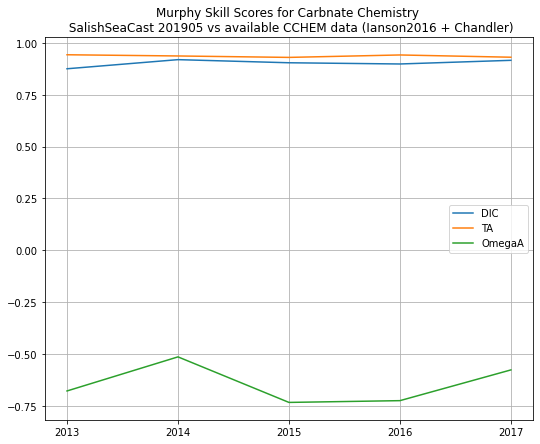

In [81]:
fact = 0.35
fig, axs = plt.subplots(1,1, figsize=(25*fact, 20.1*fact), facecolor='w', edgecolor='k')

axs.plot(np.arange(2013,2018,1),ss_dic, label = 'DIC')
axs.plot(np.arange(2013,2018,1),ss_alk, label = 'TA')
axs.plot(np.arange(2013,2018,1),ss_OmegaA, label = 'OmegaA')
axs.set_xticks(np.arange(2013,2018,1))
axs.set_title('Murphy Skill Scores for Carbnate Chemistry \n SalishSeaCast 201905 vs available CCHEM data (Ianson2016 + Chandler)')
axs.legend(loc='best')
axs.grid()

Omega Stats Check
year 2013
MSE of model 0.09485436214925132
variance of obs 0.06014475037998977
skill score... -0.5771012690213022
year 2014
MSE of model 0.1309049408765959
variance of obs 0.07798594246625938
skill score... -0.678570992884159
year 2015
MSE of model 0.11215362469756211
variance of obs 0.07406819818882368
skill score... -0.5141940460283159
year 2016
MSE of model 0.09483865462867322
variance of obs 0.054698609763976745
skill score... -0.733840312174292
year 2017
MSE of model 0.12258110057905856
variance of obs 0.07104834929047255
skill score... -0.7253194733335833


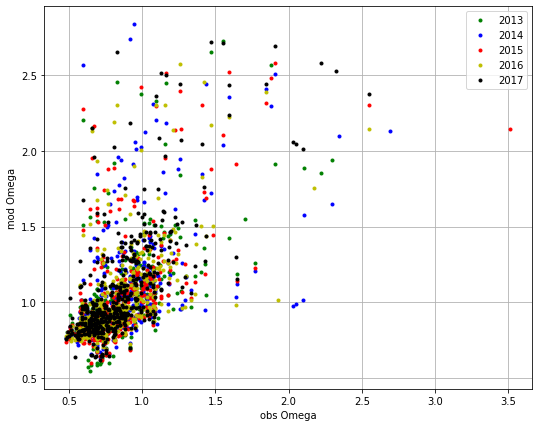

In [84]:
cols = ['g','b','r','y','k']

fact = 0.35
fig, axs = plt.subplots(1,1, figsize=(25*fact, 20.1*fact), facecolor='w', edgecolor='k')

print('Omega Stats Check')
for i in range(0,5):

    yr = 2013+i
    dset = 'COMB'
    fname_obs = f'./extracted_calculated/OBS_{dset}_MASKED_umolL.csv'
    fname_mod = f'./extracted_calculated/YR{yr}_{dset}_salspace_modeloutput_with_Omega.csv'

    OmegaA_obs = df_obs['OmegaA'].to_numpy()
    OmegaA_mod = df_mod['OmegaA'].to_numpy()

    df_obs = pd.read_csv(fname_obs)
    df_mod = pd.read_csv(fname_mod)
    
    OmegaA_mod_m = OmegaA_mod[~np.isnan(OmegaA_mod) & (OmegaA_mod <1e10)]
    OmegaA_obs_m = OmegaA_obs[~np.isnan(OmegaA_mod) & (OmegaA_mod <1e10)]

    predicted = OmegaA_mod_m;
    reference = OmegaA_obs_m;
    
    rmse2 = rmsd(predicted,reference)**2
    sdev2 = np.std(reference,ddof=1)**2
    
    print(f'year {yr}')
    print(f'MSE of model {rmse2}')
    print(f'variance of obs {sdev2}')
    print(f'skill score... {skill_score_murphy(predicted,reference)}')
#     print(rmse2/sdev2)
#     print(skill_score_murphy(predicted,reference))
    # Calculate standard deviation
#     sdev2 = np.std(OmegaA_obs_m,ddof=1)**2
    axs.plot(OmegaA_obs_m,OmegaA_mod_m, label = f'{yr}',color = cols[i],marker = '.', linestyle = 'none')
    axs.grid()
    axs.legend()
    axs.set_xlabel('obs Omega')
    axs.set_ylabel('mod Omega')